# Pattern Analysis
https://web.ist.utl.pt/rmch/dash/guides/AssociationRuleMining%20in%20Python.html

Association Pattern Analysis

- What are the aisles most purchased together?
- Which aisles are most reordered together?
- Which aisles are most ordered isolately?

ARM Resources
- https://www.kaggle.com/code/datatheque/association-rules-mining-market-basket-analysis/notebook
- https://comum.rcaap.pt/bitstream/10400.26/37552/1/Tese_JoanaOliveira.pdf

# File and libraries

In [235]:
import pandas as pd
import scipy.stats as stats
from mlxtend.frequent_patterns import apriori, association_rules



- apriori method - is used to first identify the most frequent itemsets in the data.
    - How does it work?
        - It takes a dataset of transactions (or a binary dataframe where each column represents an item and each row represents a transaction).
        - It finds frequent itemsets, meaning items that appear together in at least a minimum number of transactions (defined by min_support).

- association_rules - After obtaining frequent itemsets using apriori, you can extract association rules using association_rules.

    - How does it work?
        - It uses the frequent itemsets to generate rules like:
            {A} → {B} (if a customer buys A, there is a high probability they will buy B).
        - It evaluates rule strength using metrics such as:
        -   support → how often the rule appears in the dataset.
        - confidence → how often B is bought when A is bought.
        - lift → whether A and B occur together more often than expected by chance.

***Summary***
- Use Apriori (apriori) to find groups of items frequently bought together.
- Use Association Rules (association_rules) to generate rules like “if customers buy A, they are likely to buy B.”

## DSLabs

In [236]:
%run "scripts/dslabs_functions.py"

dslabs_functions lodaded


# data functions

In [237]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [238]:
import pandas as pd
import numpy as np



#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase
filepath = r'data/citi_bike_pre_proc.csv'

excel_mapping_filepath=r'data/citi_bike_values_encoded_pattern_analysis.xlsx'

file_tag = 'Citi Bike'



In [239]:
test_data = True
# test_data = False

# Load the data
if test_data:
    df = pd.read_csv(filepath, na_values="")

    df: DataFrame = df.sample(frac=0.1, replace = False)

else:
    # If not test_data, load the entire dataset
    df = pd.read_csv(filepath)

id_cols=['ride_id',
         'start_time', 
         'end_time',
         'start_station',
         'end_station',
         'start_station_id',
         'end_station_id',
         'start_lat',
         'start_lng', 
         'hour',
         'end_lat', 
         'end_lng',
         'wmo_weather_code',
         'snowfall_cm',
         'ride_duration_sec']
#remove also col = 'snowfall_cm' because it has only 0 values in our dataset
#remove also start_station and end_Station = they have too many unique values(around 2k) which will make the encoding process very slow

# Remove unnecessary columns
df = df.drop(columns=id_cols, axis=1)

df_enc = df.copy()  # DataFrame com as variáveis codificadas

display(df_enc.info())
display(df_enc.shape)


#alterar consoante a necessidade:
#- se quiser considerar a remoçao de outliers, alterar para "df_prep_outl"
#- se nao quiser considerar a remoçao de outliers, alterar para "df_enc"
use_df = "df_enc"  # Pode ser "df_enc" ou "df_prep_outl"
#alterar consoante a necessidade:

#- se quiser considerar a remoçao de outliers, alterar para "df_prep_outl"
#- se nao quiser considerar a remoçao de outliers, alterar para "df_enc"
#use_df_in_scaling = "df_prep_outl_remov_final"  # Pode ser "df_enc" ou "df_prep_outl"
use_df_in_feat_eng = "df_prep_outl"  # Pode ser "df_enc", "df_prep_outl", "df_prep_scal"
use_df_in_pattern = "df_prep_feat"  # Pode ser "df_enc", "df_prep_outl", "df_prep_scal", "df_prep_feat_eng"



<class 'pandas.core.frame.DataFrame'>
Index: 319360 entries, 1307821 to 613554
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bike_type            319360 non-null  object 
 1   user_type            319360 non-null  object 
 2   start_borough        319360 non-null  object 
 3   end_borough          319360 non-null  object 
 4   day_of_month         319360 non-null  int64  
 5   day_of_week          319360 non-null  object 
 6   is_weekend           319360 non-null  int64  
 7   time_of_day          319360 non-null  object 
 8   ride_duration_min    319360 non-null  float64
 9   temperature_2m       319360 non-null  float64
 10  rain_mm              319360 non-null  float64
 11  cloud_cover_low_pct  319360 non-null  int64  
 12  wind_speed_10m       319360 non-null  float64
 13  wmo_weather_desc     319360 non-null  object 
 14  ride_distance_km     319360 non-null  float64
 15  ride_avg_speed  

None

(319360, 16)

In [240]:
summary = df.describe(include='all')

display(summary)

,bike_type,user_type,start_borough,end_borough,day_of_month,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
count,319360,319360,319360,319360,319360.000000,319360,319360.000000,319360,319360.000000,319360.000000,319360.000000,319360.000000,319360.000000,319360,319360.000000,319360.000000
unique,2,2,6,6,NaN,7,NaN,4,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
top,electric_bike,member,Manhattan,Manhattan,NaN,Monday,NaN,afternoon,NaN,NaN,NaN,NaN,NaN,Overcast,NaN,NaN
freq,209297,260041,202278,201883,NaN,56914,NaN,104596,NaN,NaN,NaN,NaN,NaN,137028,NaN,NaN
mean,NaN,NaN,NaN,NaN,16.669123,NaN,0.270425,NaN,13.016397,13.085141,0.078876,20.057002,15.411847,NaN,2.003721,10.982313
std,NaN,NaN,NaN,NaN,8.268486,NaN,0.444180,NaN,20.051471,5.272667,0.360414,34.893295,7.204430,NaN,1.747572,5.677260
min,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,NaN,1.001633,0.600000,0.000000,0.000000,0.800000,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,10.000000,NaN,0.000000,NaN,5.163396,9.000000,0.000000,0.000000,10.000000,NaN,0.837323,8.257776
50%,NaN,NaN,NaN,NaN,17.000000,NaN,0.000000,NaN,8.972792,12.500000,0.000000,0.000000,14.900000,NaN,1.487656,10.976979
75%,NaN,NaN,NaN,NaN,24.000000,NaN,1.000000,NaN,15.724387,17.100000,0.000000,21.000000,20.200000,NaN,2.610994,13.829523


In [241]:
display(df_enc.columns)

display(df_enc.shape)

Index(['bike_type', 'user_type', 'start_borough', 'end_borough',
       'day_of_month', 'day_of_week', 'is_weekend', 'time_of_day',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km',
       'ride_avg_speed'],
      dtype='object')

(319360, 16)

In [242]:
df.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
1307821,electric_bike,casual,Brooklyn,Bronx,27,Saturday,1,afternoon,4.545467,14.3,0.0,16,25.3,Overcast,0.869337,11.475214
1808,electric_bike,casual,Brooklyn,Brooklyn,28,Sunday,1,evening,21.745383,18.6,0.0,3,11.3,Overcast,3.859863,10.650158
2659028,classic_bike,member,Manhattan,Manhattan,30,Tuesday,0,afternoon,1.968700,19.9,0.0,2,11.3,Overcast,0.415646,12.667622
1734283,classic_bike,member,Brooklyn,Brooklyn,14,Sunday,1,afternoon,9.422467,20.8,0.0,0,21.3,Overcast,1.244691,7.925893
2026041,electric_bike,member,Brooklyn,Brooklyn,26,Friday,0,night,2.598533,5.0,0.0,0,8.2,Mainly clear,0.563905,13.020530


### Change col time_of_day and day_of_week

In [134]:
#change time_of_day


#change day_of_week

def weekday_group(day_of_week):
    if day_of_week in ['Monday', 'Tuesday']:
        return 'early_week'
    elif day_of_week in ['Wednesday', 'Thursday']:
        return 'mid_week'
    else:  # Friday, Saturday, Sunday
        return 'weekend'

df_enc['weekday_group'] = df_enc['day_of_week'].apply(weekday_group)
df['weekday_group'] = df['day_of_week'].apply(weekday_group)
display(df_enc['weekday_group'].value_counts())

#droping redundant columns that we no longer need
df_enc.drop(columns='day_of_week', inplace=True)
df.drop(columns='day_of_week', inplace=True)

df_enc.drop(columns='is_weekend', inplace=True)
df.drop(columns='is_weekend', inplace=True)

df_enc.drop(columns='hour', inplace=True)
df.drop(columns='hour', inplace=True)

display(df_enc.head())

display(df_enc.shape)
display(df.shape)


weekday_group
weekend       520068
early_week    450911
mid_week      306460
Name: count, dtype: int64

,bike_type,user_type,start_borough,end_borough,day_of_month,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,weekday_group
456401,electric_bike,member,Manhattan,Manhattan,11,morning,2.792717,9.6,0.2,100,8.1,Drizzle: Light,0.890268,19.126927,mid_week
845642,electric_bike,member,Bronx,Bronx,29,afternoon,17.352433,26.1,1.8,5,10.5,Rain: Slight,5.906246,20.422193,early_week
2316829,electric_bike,member,Manhattan,Manhattan,19,evening,20.756367,8.5,0.0,100,11.2,Overcast,2.664389,7.701893,weekend
268933,electric_bike,casual,Manhattan,Manhattan,20,afternoon,67.712450,19.4,0.0,0,28.8,Mainly clear,3.043264,2.696637,weekend
736686,electric_bike,member,Brooklyn,Brooklyn,25,morning,4.245117,6.7,0.0,0,16.6,Partly cloudy,0.943947,13.341634,mid_week


(1277439, 15)

(1277439, 15)

# Data encoding for Pattern mining 

## Encoding Detail

- Ordinal enconding:
  - bike_type
    - 0: classic
    - 1: eletric
  - user_type
    - 0: casual
    - 1: member

- Hierachical encoding: Simbolyic Variables
  - start_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
  - end_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
 

- Cyclical enconding: Simbolyic Variables
  - day_of_week
  - time_of_day
  - hour

- Dummyfication:
  - start_borough
  - end_borough
  - wmo_weather_desc 


- Numeric Values that don't need encoding
  - hour
  - day_of_month
  - is_weekend
  - ride_duration_min
  - temperature_2m
  - rain_mm
  - wmo_weather_code ?????
  - cloud_cover_low_pct
  - wind_speed_10m
  - ride_distance_km
  - ride_avg_speed

Note: week_of_month and day in our case are ordinal variables, and not cyclical, because our dataset only has data for 1 month, nov/19, which means that these two variables don't repeat over time in our dataset.

## Ordinal enconding





In [25]:
from pandas import Series, DataFrame, to_numeric, to_datetime

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    
    for c in df.columns:
        if 2 == nr_values[c]:  # Colunas com exatamente 2 valores únicos
            variable_types["binary"].append(c)
        else:
            if df[c].dtype == 'datetime64[ns, UTC]':  # Verifica se a coluna já é datetime
                variable_types["date"].append(c)
            else:
                try:
                    df[c] = to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

# Uso da função
variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)

{'numeric': ['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed'], 'binary': ['bike_type', 'user_type', 'is_weekend'], 'date': [], 'symbolic': ['start_borough', 'end_borough', 'day_of_week', 'time_of_day', 'wmo_weather_desc']}


##### bulk Symbolic mapping through Excel

    - Simbolyc
        -...

    - Binary
        - is_weekend
        - bike_type
            - 0: classic
            - 1: eltric
        - user_type
            - 0: classic
            - 1: member

In [35]:


# Generalized function to encode any column based on a mapping dictionary
def encode_column_with_mapping(df, column, mapping_dict, default_value=np.nan):
    """
    Encode a column based on a mapping dictionary.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the column to encode.
    column (str): The column name to encode.
    mapping_dict (dict): Dictionary where keys are the original values and values are the encodings.
    default_value: Value to assign if the key is not found in the mapping dict (default is NaN).
    
    Returns:
    pd.Series: Encoded column.
    """
    return df[column].map(mapping_dict).fillna(default_value)



def sheet_to_dict(excel_file, sheet_name):
    """
    Converts a sheet in an Excel file to a dictionary with the first column as the key and the second as the value.
    
    Args:
    excel_file (str): Path to the Excel file.
    sheet_name (str): Name of the sheet to convert.
    
    Returns:
    dict: A dictionary with keys from the first column and values from the second column.
    """
    # Read the sheet into a DataFrame
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # Ensure that there are at least two columns
    if df.shape[1] < 2:
        raise ValueError(f"The sheet '{sheet_name}' does not have at least two columns.")
    
    # Create a dictionary from the first and second columns
    mapping_dict = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))
    
    return mapping_dict



In [27]:
excel_file = pd.ExcelFile(excel_mapping_filepath)
sheet_names = excel_file.sheet_names  # List of all sheet names

# Iterate over each sheet and map the corresponding column
for sheet in sheet_names:
    # Assuming the sheet names match the column names in data_enc
    if sheet in df_enc.columns:
        # Load the sheet as a dictionary
        category_mapping = sheet_to_dict(excel_mapping_filepath, sheet)
        
        # Encode the corresponding column in data_enc using the mapping
        df_enc[sheet] = encode_column_with_mapping(df_enc, sheet, category_mapping)
        print(f'{sheet} column encoded')

    else:
        print(f"Warning: No matching column found in data_enc for sheet '{sheet}'")




bike_type column encoded
user_type column encoded


In [28]:
df_enc.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
2035177,0,1,Manhattan,Manhattan,6,Saturday,1,night,24.605283,2.9,0.0,100,14.6,Overcast,4.170525,10.169828
2511103,0,1,Brooklyn,Brooklyn,6,Saturday,1,night,4.564050,3.2,0.0,22,15.7,Overcast,0.894513,11.759465
2124788,1,1,Manhattan,Manhattan,6,Saturday,1,evening,13.966867,8.5,0.0,38,16.1,Partly cloudy,2.097759,9.011725
2805427,1,1,Manhattan,Manhattan,30,Tuesday,0,night,13.289483,11.8,0.0,100,10.8,Overcast,0.304663,1.375508
72637,1,1,Brooklyn,Brooklyn,22,Monday,0,evening,13.992167,9.3,0.0,0,10.8,Clear sky,3.369099,14.447080


In [30]:
display(df_enc['bike_type'].value_counts())
display(df_enc['user_type'].value_counts())


bike_type
1    209205
0    110155
Name: count, dtype: int64

user_type
1    260592
0     58768
Name: count, dtype: int64

In [31]:
for v in variable_types["symbolic"]:
    print(v, df_enc[v].unique())

start_borough ['Manhattan' 'Brooklyn' 'Bronx' 'Queens' 'Staten Island' 'Jersey City']
end_borough ['Manhattan' 'Brooklyn' 'Bronx' 'Queens' 'Staten Island' 'Jersey City']
day_of_week ['Saturday' 'Tuesday' 'Monday' 'Thursday' 'Friday' 'Sunday' 'Wednesday']
time_of_day ['night' 'evening' 'morning' 'afternoon']
wmo_weather_desc ['Overcast' 'Partly cloudy' 'Clear sky' 'Mainly clear' 'Drizzle: Light'
 'Rain: Slight' 'Drizzle: Moderate' 'Drizzle: Dense' 'Rain: Moderate']


## Dummyifcation enconding
- Apply dummyification method to the following variables:
    - bike_type
    - user_type
    - start_borough
    - end_borough
    - wmo_weather_desc
    - day_of_week
    - time_of_day
    - user_type
    - bike_type
    - is_weekend


In [243]:
# Apply one-hot encoding to the symbolic variables
df_enc = pd.get_dummies(df, columns=[
    "bike_type",
    "user_type",
    "is_weekend",
    "start_borough",
     "end_borough", 
     "wmo_weather_desc",
     'day_of_week',
     'time_of_day'], dtype=int)


#dropping new columns created with dummyification because we already have is_weekend
#df_enc = df_enc.drop(columns=['day_of_week_Sunday', 'day_of_week_Saturday'], axis=1)
display(df_enc.head())

,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
1307821,27,4.545467,14.3,0.0,16,25.3,0.869337,11.475214,0,1,...,0,1,0,0,0,0,1,0,0,0
1808,28,21.745383,18.6,0.0,3,11.3,3.859863,10.650158,0,1,...,0,0,1,0,0,0,0,1,0,0
2659028,30,1.968700,19.9,0.0,2,11.3,0.415646,12.667622,1,0,...,0,0,0,0,1,0,1,0,0,0
1734283,14,9.422467,20.8,0.0,0,21.3,1.244691,7.925893,1,0,...,0,0,1,0,0,0,1,0,0,0
2026041,26,2.598533,5.0,0.0,0,8.2,0.563905,13.020530,0,1,...,0,0,0,0,0,0,0,0,0,1


In [244]:
df_enc.shape

(319360, 46)

In [245]:
df_enc.columns

Index(['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm',
       'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km',
       'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike',
       'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Jersey City', 'start_borough_Manhattan',
       'start_borough_Queens', 'start_borough_Staten Island',
       'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island', 'wmo_weather_desc_Clear sky',
       'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight',
       'day_of_week_Fr

# Data Preparation for Pattern mining

## Outliers Analysis

### Check distribuition of numeric variable to see if we have outliers with strange values


### Boxplot for Single Variable Values

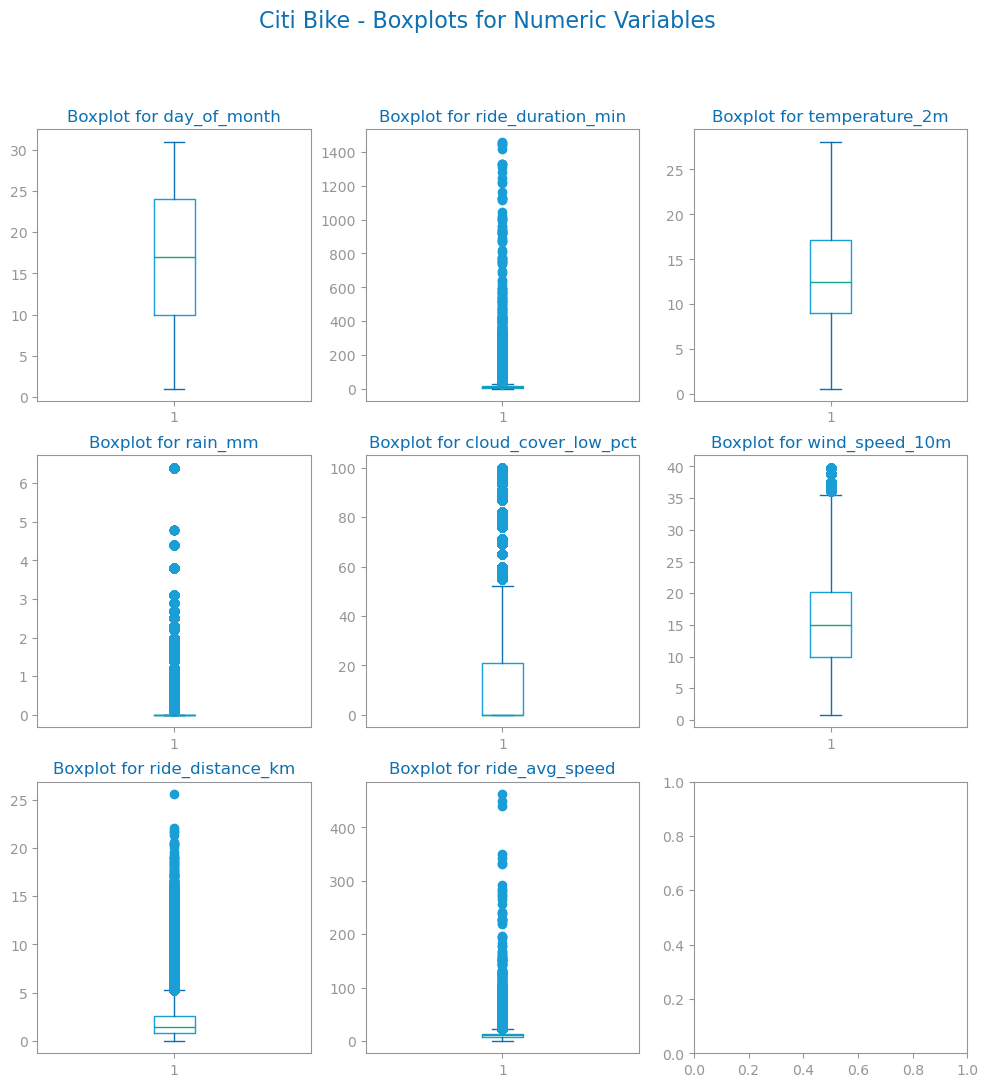

In [246]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT
import pandas as pd

# Obter as variáveis categorizadas pela função get_variable_types
variable_types: dict[str, list] = get_variable_types(df_enc)

# Apenas variáveis numéricas são usadas para os boxplots
numeric = variable_types.get('numeric', [])

# Verificar se a lista de variáveis numéricas não está vazia
if numeric:
    rows, cols = define_grid(len(numeric))  # Definir o número de linhas e colunas com base no número de variáveis
    fig, axs = subplots(rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False)
    fig.suptitle(f"{file_tag} - Boxplots for Numeric Variables", fontsize=16)

    # Iterar sobre as variáveis numéricas e criar os subplots
    i, j = 0, 0
    for n in numeric:
        # Garantir que apenas valores numéricos são passados para boxplot
        data = df_enc[n].dropna().values
        
        if pd.api.types.is_numeric_dtype(df[n]):
            axs[i, j].set_title(f"Boxplot for {n}")
            axs[i, j].boxplot(data)
        
        # Mover para o próximo subplot
        i, j = (i + 1, 0) if (j + 1) % cols == 0 else (i, j + 1)
    #savefig(f"images/{file_tag}_profiling_boxplot_single_num_vars.png")
    # Mostrar os gráficos
    show()
else:
    print("There are no numeric variables.")

#### Analysis of the numeric variable boxplots

- Looking at the numerical variables:
    - ride_distance_km
    - ride_avg_speed
    - wind_speed_10m
    - temperature_2m
    - ride_duration_min

- We can see many outliers in ride_distance_km, with some rides lasting up to 1400 minutes (24 hours). On the CitiBike website, it says members can have 45 minutes and casual users and 30 minutes single rides on a single day(24h), and they will have with extra charges for longer trips. 
    - These outliers are likely users who kept the bike for a full day and paid for the extra time.
    - Since these are probably real cases, we’ll keep them in the dataset for analysis.

- In the case of ride_avg_speed, we have values above 100 km/h, which is not possible. According to the citibike website, we can see that the limit of the citi bikes is 18mph(28,9km/h).
    - These are likely cases where, for some reason, the ride duration is incorrect, with very large values relative to a short distance—probably application errors, or cases where users did not turn off the app and the time continued to count.
    - That said, we will remove these observations from the dataset by limiting it to observations with ride_avg_speed < 30 km/h."

### Drop Outliers

In [247]:
df_prep_outl = df_enc.copy()

In [89]:
df_prep_outl.shape

(319360, 45)

In [248]:
df_prep_outl = df_enc[
    (df_enc['ride_avg_speed'] < 30)
]

display(df_prep_outl.shape)
display(df_prep_outl.head())

(318834, 46)

,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
1307821,27,4.545467,14.3,0.0,16,25.3,0.869337,11.475214,0,1,...,0,1,0,0,0,0,1,0,0,0
1808,28,21.745383,18.6,0.0,3,11.3,3.859863,10.650158,0,1,...,0,0,1,0,0,0,0,1,0,0
2659028,30,1.968700,19.9,0.0,2,11.3,0.415646,12.667622,1,0,...,0,0,0,0,1,0,1,0,0,0
1734283,14,9.422467,20.8,0.0,0,21.3,1.244691,7.925893,1,0,...,0,0,1,0,0,0,1,0,0,0
2026041,26,2.598533,5.0,0.0,0,8.2,0.563905,13.020530,0,1,...,0,0,0,0,0,0,0,0,0,1


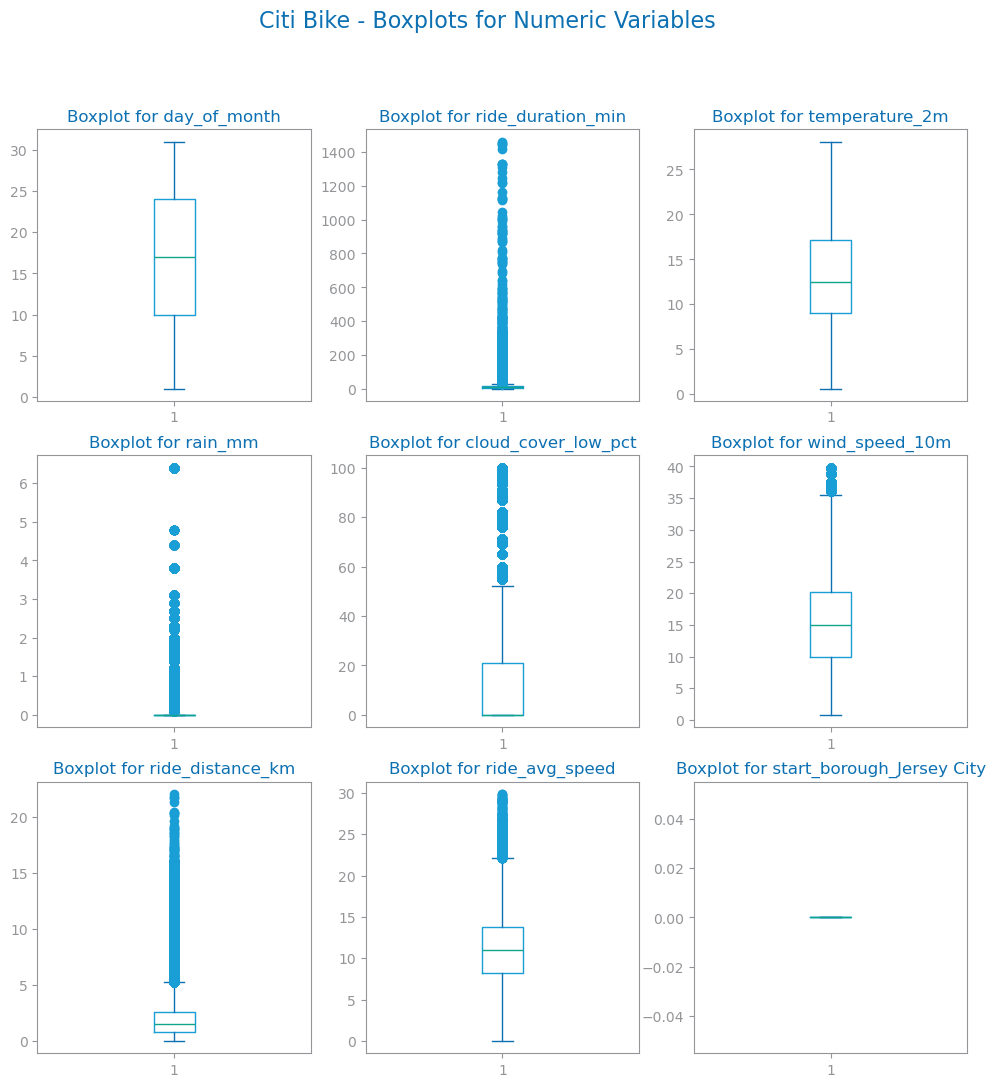

In [249]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT
import pandas as pd

# Obter as variáveis categorizadas pela função get_variable_types
variable_types: dict[str, list] = get_variable_types(df_prep_outl)

# Apenas variáveis numéricas são usadas para os boxplots
numeric = variable_types.get('numeric', [])

# Verificar se a lista de variáveis numéricas não está vazia
if numeric:
    rows, cols = define_grid(len(numeric))  # Definir o número de linhas e colunas com base no número de variáveis
    fig, axs = subplots(rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False)
    fig.suptitle(f"{file_tag} - Boxplots for Numeric Variables", fontsize=16)

    # Iterar sobre as variáveis numéricas e criar os subplots
    i, j = 0, 0
    for n in numeric:
        # Garantir que apenas valores numéricos são passados para boxplot
        data = df_prep_outl[n].dropna().values
        
        if pd.api.types.is_numeric_dtype(df_prep_outl[n]):
            axs[i, j].set_title(f"Boxplot for {n}")
            axs[i, j].boxplot(data)
        
        # Mover para o próximo subplot
        i, j = (i + 1, 0) if (j + 1) % cols == 0 else (i, j + 1)
    #savefig(f"images/{file_tag}_profiling_boxplot_single_num_vars.png")
    # Mostrar os gráficos
    show()
else:
    print("There are no numeric variables.")

In [250]:
df_prep_outl.shape

(318834, 46)

## Feature Selection

In [251]:
use_df_in_feat_eng="df_prep_outl"

In [253]:
df_prep_outl.shape
use_df_in_feat_eng = "df_prep_outl"

# Escolher o DataFrame a ser utilizado com base na variável 'use_df_in_feat_eng' (feature engineering)
if use_df_in_feat_eng == "df_enc":
    df_to_use_feat = df_enc
elif use_df_in_feat_eng == 'df_prep_outl':
    df_to_use_feat = df_prep_outl
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_feat_eng}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df_in_feat_eng} dataset, which means that we are {'not ' if use_df_in_feat_eng == 'df_enc' else ''}considering the removal of outliers and also scaled data")
print(f"Shape of dataset: {df_to_use_feat.shape}")


We will use the dataset df_prep_outl dataset, which means that we are considering the removal of outliers and also scaled data
Shape of dataset: (318834, 46)


### Feat 2 - Variance Threshold (Remove Low-Variance Features)


In [254]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal

(319360, 16)

(319360, 46)

(318834, 46)

In [255]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
selector = VarianceThreshold(threshold=0.1)  # Ajuste o threshold conforme necessário
X_reduced = selector.fit_transform(df_to_use_feat)

# Get selected features
selected_features = df_to_use_feat.columns[selector.get_support()]
print(selected_features)


Index(['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm',
       'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km',
       'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike',
       'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Brooklyn', 'start_borough_Manhattan',
       'end_borough_Brooklyn', 'end_borough_Manhattan',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Overcast',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'time_of_day_afternoon', 'time_of_day_evening',
       'time_of_day_morning'],
      dtype='object')


In [258]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold


# Print initial features
print("Initial features:\n", df_to_use_feat.columns.tolist())

# Compute variance for each feature
feature_variance = df_to_use_feat.var()
print("\nFeature Variance:\n", feature_variance)

# Define threshold (adjust based on the dataset)
threshold = 0.01
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the dataset
X_reduced = selector.fit_transform(df_to_use_feat)

# Get selected features
initial_features = list(set(df_to_use_feat.columns))
removed_features = list(set(df_to_use_feat.columns) - set(selected_features))
selected_features = df_to_use_feat.columns[selector.get_support()]


# Print results
print("Initial Features df_prep:\n", initial_features)
print("\nRemoved Features (low variance < {:.3f}):\n".format(threshold), removed_features)
print("\nFinal Features list:\n", selected_features.tolist())


Initial features:
 ['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1', 'start_borough_Bronx', 'start_borough_Brooklyn', 'start_borough_Jersey City', 'start_borough_Manhattan', 'start_borough_Queens', 'start_borough_Staten Island', 'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City', 'end_borough_Manhattan', 'end_borough_Queens', 'end_borough_Staten Island', 'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light', 'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear', 'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy', 'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_we

In [259]:
selected_features

Index(['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm',
       'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km',
       'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike',
       'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening'

In [260]:
df_prep_feat_var = df_to_use_feat[selected_features]

In [263]:
df_prep_feat_var.shape

(318834, 40)

In [262]:
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal
display(df_to_use_feat.shape) # df after enconding and data prep outlier removal
display(df_prep_feat_var.shape) 

(319360, 46)

(318834, 46)

(318834, 46)

(318834, 40)

### Feat 3 - Drop Redundant Variables
    - Correlation interpretation - values between [-1,1]:
        - 0.9 and above: Very strong correlation (typically, > 0.9 is considered almost perfect).
        - 0.7 to 0.9: Strong correlation.
        - 0.3 to 0.7: Moderate correlation.
        - 0.1 to 0.3: Weak correlation.
        - 0 to 0.1: No significant correlation.       

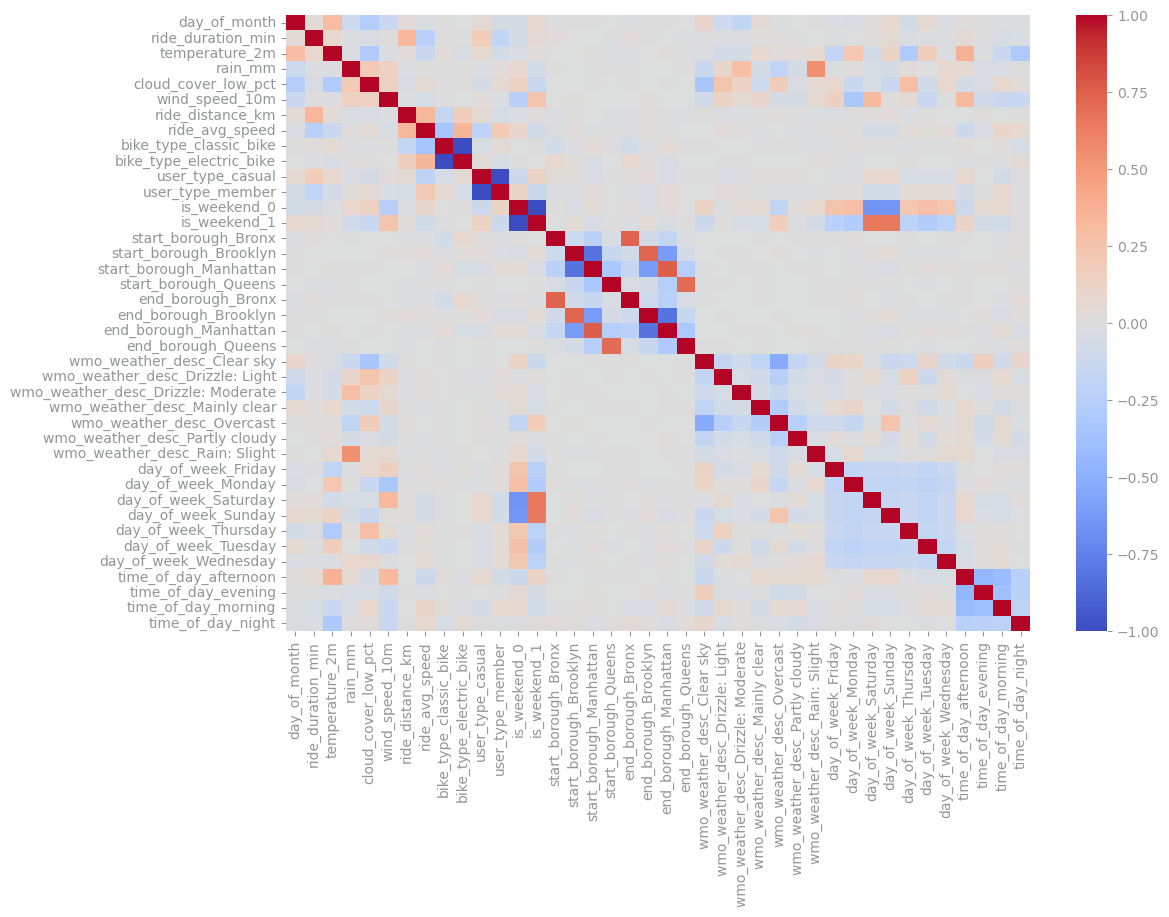

In [264]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.show()

In [265]:
import numpy as np

# Calculate correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Identify pairs of highly correlated features (correlation > 0.8)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to store the pairs of highly correlated features
redundant_pairs = []

# Loop through each column to find pairs with correlation > 0.8
for column in upper_tri.columns:
    for row in upper_tri.index:
        if upper_tri.loc[row, column] > 0.8:
            redundant_pairs.append((row, column, upper_tri.loc[row, column]))

# Print initial features count
print(f"Initial number of features: {len(df_prep_feat_var.columns)}")

# Print redundant pairs
print(f"Redundant pairs (correlation > 0.8):")
for pair in redundant_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

# Identify the features to drop based on redundancy
to_drop = [pair[1] for pair in redundant_pairs]

# Print features that will be dropped
print(f"Number of features dropped: {len(to_drop)}")
print(f"Features dropped: {to_drop}")

# Drop the correlated features
df_prep_final = df_prep_feat_var.drop(columns=to_drop)

# Print remaining features count
print(f"Remaining features: {len(df_prep_final.columns)}")
print(f"Remaining features: {df_prep_final.columns.tolist()}")


Initial number of features: 40
Redundant pairs (correlation > 0.8):
Number of features dropped: 0
Features dropped: []
Remaining features: 40
Remaining features: ['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1', 'start_borough_Bronx', 'start_borough_Brooklyn', 'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens', 'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light', 'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear', 'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy', 'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_o

In [266]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal
display(df_prep_feat_var.shape) 
display(df_prep_final.shape) 

(319360, 16)

(319360, 46)

(318834, 46)

(318834, 40)

(318834, 40)

## Discritization of the numerical variable

In [267]:
df_prep_feat_var.head()

,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
1307821,27,4.545467,14.3,0.0,16,25.3,0.869337,11.475214,0,1,...,0,1,0,0,0,0,1,0,0,0
1808,28,21.745383,18.6,0.0,3,11.3,3.859863,10.650158,0,1,...,0,0,1,0,0,0,0,1,0,0
2659028,30,1.968700,19.9,0.0,2,11.3,0.415646,12.667622,1,0,...,0,0,0,0,1,0,1,0,0,0
1734283,14,9.422467,20.8,0.0,0,21.3,1.244691,7.925893,1,0,...,0,0,1,0,0,0,1,0,0,0
2026041,26,2.598533,5.0,0.0,0,8.2,0.563905,13.020530,0,1,...,0,0,0,0,0,0,0,0,0,1


In [268]:
use_df_in_discrit = "df_prep_feat_var"

In [269]:
# Escolher o DataFrame a ser utilizado com base na variável 'use_df_in_discrit' (clustering)
if use_df_in_discrit == "df_enc":
    df_to_use_discrit = df_enc
elif use_df_in_discrit == "df_prep_outl":
    df_to_use_discrit = df_prep_outl
elif use_df_in_discrit == "df_prep_feat_var":
    df_to_use_discrit = df_prep_feat_var
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_discrit}. Choose either 'df_enc', 'df_prep_outl', or 'df_prep_feat_var'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df_in_discrit} dataset")
print(f"Shape of dataset: {df_to_use_discrit.shape}")


We will use the dataset df_prep_feat_var dataset
Shape of dataset: (318834, 40)


### Apply cut to discretize the numeric variables that follows a normal distribution
    - On this method we don't need to define the limits for each bin, cut will define them and distribute the values by the bins with the same lenght

In [134]:
df_to_use_discrit.head()
display(df_to_use_discrit.shape)

(318808, 29)

In [603]:

#don't consider the binary variables, becasue these ones are already encoded (0 or 1)

binary_var = [col for col in df_discrit.columns if df_discrit[col].nunique() ==2]

#also not considering bellow columns for qui-cut discretization, because the ydon't follow a normal distribution
except_cols = [
    'temperature_2m',
    'wind_speed_10m',
    'cloud_cover_low_pct',
    'day_of_month']

# List of columns to apply the qcut transformation
columns_to_bin = df_discrit.drop(columns=binary_var + except_cols, axis=1).columns


# Loop through the columns and apply cut with specific labels
for v in columns_to_bin:
    if v == 'ride_duration_min':
        df_discrit[v], bins_ride_duration = pd.cut(df_discrit[v], 3, labels=['short', 'medium', 'long'], retbins=True)
        print(f"Limits for {v}: {bins_ride_duration}")
    elif v == 'ride_distance_km':
        df_discrit[v], bins_ride_distance = pd.cut(df_discrit[v], 3, labels=['short', 'medium', 'long'], retbins=True)
        print(f"Limits for {v}: {bins_ride_distance}")
    elif v == 'ride_avg_speed':
        df_discrit[v], bins_ride_avg_speed = pd.cut(df_discrit[v], 3, labels=['slow', 'medium', 'fast'], retbins=True)
        print(f"Limits for {v}: {bins_ride_avg_speed}")

# Check the results
display(df_discrit[['ride_duration_min', 'ride_distance_km', 'ride_avg_speed']].value_counts())
display(df_discrit[['ride_duration_min']].value_counts())
display(df_discrit[['ride_distance_km']].value_counts())
display(df_discrit[['ride_avg_speed']].value_counts())


Limits for ride_duration_min: [-4.69140617e-01  4.91566089e+02  9.82129628e+02  1.47269317e+03]
Limits for ride_distance_km: [-0.02522993  8.40997648 16.81995295 25.22992943]
Limits for ride_avg_speed: [ -0.77765012 259.2167082  518.4334164  777.6501246 ]


ride_duration_min  ride_distance_km  ride_avg_speed
short              short             slow              948233
                   medium            slow                9480
medium             short             slow                 122
short              long              slow                 115
long               short             slow                  95
short              medium            medium                20
medium             medium            slow                   6
short              short             medium                 5
                   medium            fast                   1
                   long              medium                 1
long               medium            slow                   1
Name: count, dtype: int64

ride_duration_min
short                957855
medium                  128
long                     96
Name: count, dtype: int64

ride_distance_km
short               948455
medium                9508
long                   116
Name: count, dtype: int64

ride_avg_speed
slow              958052
medium                26
fast                   1
Name: count, dtype: int64

In [575]:
display(df_discrit.head())

,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,end_borough_Bronx,end_borough_Brooklyn,end_borough_Manhattan,end_borough_Queens,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night
3138759,27,short,9.7,0.0,2,13.0,short,slow,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3173276,11,short,15.0,0.2,10,21.4,short,slow,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
977436,12,short,17.8,0.4,100,24.0,short,slow,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3122612,10,short,10.9,0.0,5,6.4,short,slow,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1353311,18,short,7.6,0.0,7,12.6,short,slow,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


### Testing bin limits for cols ride_duration_min, ride_distance_km, ride_avg_speed

In [148]:
import pandas as pd

# Função para binning e contagem de ocorrências
def bin_and_count(df, column, bins, labels):
    df_copy = df.copy()  # Evitar modificar o DataFrame original
    # Criar a nova coluna com os bins
    df_copy[f'{column}_bin'] = pd.cut(df_copy[column], bins=bins, labels=labels, right=False)
    # Contar o número de ocorrências em cada bin
    bin_counts = df_copy[f'{column}_bin'].value_counts().sort_index()
    return bin_counts

# Definir os intervalos (bins) e labels para cada coluna
distance_bins = [0, 2, 5, 10, 20, 30, float('inf')]
distance_labels = ['0-2 km', '2-5 km', '5-10 km', '10-20 km', '20-30 km', '+30km']

duration_bins = [0, 10, 20, 30, 45, float('inf')]
duration_labels = ['0-10 min', '10-20 min', '20-30 min', '30-45 min', '+45min']

speed_bins = [0, 5, 10, 15, 20, 25, float('inf')]
speed_labels = ['0-5 km/h', '5-10 km/h', '10-15 km/h', '15-20 km/h', '20-25 km/h', '25+ km/h']

# Analisar as distâncias menores que 3 km
unique_distances = df_to_use_discrit[df_to_use_discrit['ride_distance_km'] < 3]['ride_distance_km'].unique()
print(f"Rows with distance < 3 km: {len(unique_distances)}")
print(f"All rows: {len(df_to_use_discrit)}")

# Contar as ocorrências nos bins
distance_counts = bin_and_count(df_to_use_discrit, 'ride_distance_km', distance_bins, distance_labels)
duration_counts = bin_and_count(df_to_use_discrit, 'ride_duration_min', duration_bins, duration_labels)
speed_counts = bin_and_count(df_to_use_discrit, 'ride_avg_speed', speed_bins, speed_labels)



bins_wind = [0, 10, 20, 40, 60, float('inf')]
labels_wind = ['0_10km/h', '10_20km/h', '20_40km/h', 'very Strong', 'storm']
wind_counts = bin_and_count(df_to_use_discrit, 'wind_speed_10m', bins_wind, labels_wind)
# Apply the discretization

# Definir os bins para a precipitação (rain_mm)
rain_bins = [-0.1, 0.01, 0.5, 1.0, np.inf]  # Definição dos intervalos
rain_labels = ['no_rain', 'light_rain', 'moderate_rain', 'heavy_rain']  # Categorias
rain_counts = bin_and_count(df_to_use_discrit, 'rain_mm', rain_bins, rain_labels)  # Contagem dos bins

# Exibir os resultados
print("\nCounts for ride distance bins:")
print(distance_counts)

print("\nCounts for ride duration bins:")
print(duration_counts)

print("\nCounts for ride average speed bins:")
print(speed_counts)

print("\nCounts for wind speed bins:")
print(wind_counts)

print("\nCounts for rain bins:")
print(rain_counts)



Rows with distance < 3 km: 197931
All rows: 318808

Counts for ride distance bins:
ride_distance_km_bin
0-2 km      203577
2-5 km       94900
5-10 km      19080
10-20 km      1247
20-30 km         4
+30km            0
Name: count, dtype: int64

Counts for ride duration bins:
ride_duration_min_bin
0-10 min     175898
10-20 min     89600
20-30 min     30712
30-45 min     14795
+45min         7803
Name: count, dtype: int64

Counts for ride average speed bins:
ride_avg_speed_bin
0-5 km/h       29433
5-10 km/h      99996
10-15 km/h    135192
15-20 km/h     48869
20-25 km/h      5198
25+ km/h         120
Name: count, dtype: int64

Counts for wind speed bins:
wind_speed_10m_bin
0_10km/h        79963
10_20km/h      154672
20_40km/h       84173
very Strong         0
storm               0
Name: count, dtype: int64

Counts for rain bins:
rain_mm_bin
no_rain          277583
light_rain        24184
moderate_rain      9777
heavy_rain         7264
Name: count, dtype: int64


In [144]:
df_to_use_discrit['rain_mm'].value_counts()

rain_mm
0.0    277583
0.1     12776
0.4      3916
0.2      3850
0.5      3818
0.3      3642
0.8      2488
1.4      1592
0.6      1540
0.9      1073
1.6       897
1.8       874
0.7       858
1.2       689
2.0       647
1.0       558
6.4       372
1.7       237
2.3       236
2.7       199
1.5       173
2.5       138
3.8       127
1.1       115
1.9       112
3.1        95
4.4        87
2.9        70
2.2        28
4.8        18
Name: count, dtype: int64

### Mannual define limit of the bins for some of the variables

Suggested Binning for 

***var wind_speed_10m:***
- Calm: 0 - 10 km/h
- Moderate: 11 - 20 km/h
- Strong: 21 - 40 km/h
- Very Strong: 41 - 60 km/h
- Storm: 61+ km/h

***var temperature_2m:***
- Cold (0 - 10°C): This would represent the colder months, including early spring and late fall, as well as some of the winter months.
- Cool (10 - 20°C): This could represent spring and fall when the temperature is moderate.
- Warm (20 - 30°C): This would generally correspond to the warmer summer months.
- Hot (30°C and above): This would be reserved for exceptionally hot days, particularly during the peak of summer.

***var clowd_cover_low_pct:***
- 0-20%: Clear sky / Few clouds
- 21-50%: Scattered clouds
- 51-80%: Dense clouds
- 81-100%: Overcast

***var day_of_month:***
- 0 - 7: week_1
- 7 -14: week_2
- 14 - 21: week_3
- 21 - 31: week_4

***var rain_mm:***
- -0.1 - 0: No rain
- 0 - 0.5: light rain
- 0.5 - 1: moderate_rain
- _>1: heavy_rain

***var ride_duration_min:***         
- 0,9min - 25min: short
- 25min - 50min: medium
- 50min - 74min: long

***var ride_distance_km:***         
- -0.07km - 2,4km: short
- 2,4km - 4,8km: medium
- 4,8km - 7,2km: long

***var ride_distance_km:***         
- -0.07km - 2,4km: short
- 2,4km - 4,8km: medium
- 4,8km - 7,2km: long

***var ride_avg_speed:***         
- -0.07km/h - 9,4km/h: slow
- 9,4km/h - 18km/h: medium
- 18,2km - 27,2km: fast



In [183]:
display(df_to_use_discrit.head())

,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,...,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
1276408,16,0,7.621667,18.4,0.0,0,15.8,1.043734,8.216582,0,...,0,0,0,0,0,1,0,1,0,0
2080027,14,1,14.544000,18.5,0.0,0,23.8,2.164665,8.930135,1,...,0,0,0,1,0,0,0,1,0,0
1130043,9,0,4.642083,13.5,0.0,0,14.0,0.799836,10.338070,1,...,0,0,0,0,0,1,0,0,1,0
2632448,27,1,2.180550,9.6,0.0,7,14.9,0.546631,15.041084,0,...,0,0,1,0,0,0,0,0,1,0
2219930,7,1,1.519400,3.9,0.0,0,7.1,0.397425,15.694014,0,...,0,0,0,1,0,0,0,0,0,0


In [270]:
import pandas as pd
import numpy as np

# Define bins and labels for each feature

# Bins for ride_duration_min (duration of the ride in minutes)
bins_duration = [0, 10, 20, 30, 45, float('inf')]
labels_duration = ['0_10min','10_20min','20_30min','30_45min','+45min']

# Bins for ride_distance_km (distance of the ride in km)
bins_distance = [0, 2, 5, 10, float('inf')]
labels_distance = ['0_2km', '2_5km', '5-10km', '+10km']

# Bins for ride_avg_speed (average speed of the ride in km/h)
bins_speed = [0, 10, 20, 30, float('inf')]
labels_speed = ['0_10_kmh', '10_20_kmh', '20_30kmh','+30km_h']

# Define bins for wind speed (in km/h)
bins_wind = [0, 10, 20, 40, 60, float('inf')]
labels_wind = ['calm', 'moderate', 'strong', 'very strong', 'storm']

# Define bins for temperature (2 meters above ground, in °C)
bins_temp = [0, 10, 20, 30, float('inf')]
labels_temp = ['cold', 'cool', 'warm', 'hot']

# Define bins for cloud cover percentage
bins_cloud = [0, 20, 50, 80, 101]
labels_cloud = ['clear sky', 'scattered clouds', 'dense clouds', 'overcast']

# Define bins for precipitation (in mm)
rain_bins = [-0.1, 0, 0.5, 1.0, np.inf]
rain_labels = ['no_rain', 'light_rain', 'moderate_rain', 'heavy_rain']

# Define bins for the day of the month (grouped into weeks)
day_of_month_bins = [0, 7, 14, 21, 31]
day_of_month_labels = ['week_1', 'week_2', 'week_3', 'week_4']

# Apply the discretization (binning)

# Ride duration
df_to_use_discrit['ride_duration_min'] = pd.cut(df_to_use_discrit['ride_duration_min'], bins=bins_duration, labels=labels_duration, right=False)

# Ride distance
df_to_use_discrit['ride_distance_km'] = pd.cut(df_to_use_discrit['ride_distance_km'], bins=bins_distance, labels=labels_distance, right=False)

# Ride average speed
df_to_use_discrit['ride_avg_speed'] = pd.cut(df_to_use_discrit['ride_avg_speed'], bins=bins_speed, labels=labels_speed, right=False)

# Wind speed
df_to_use_discrit['wind_speed_10m'] = pd.cut(df_to_use_discrit['wind_speed_10m'], bins=bins_wind, labels=labels_wind, right=False)

# Temperature
df_to_use_discrit['temperature_2m'] = pd.cut(df_to_use_discrit['temperature_2m'], bins=bins_temp, labels=labels_temp, right=False)

# Cloud cover
df_to_use_discrit['cloud_cover_low_pct'] = pd.cut(df_to_use_discrit['cloud_cover_low_pct'], bins=bins_cloud, labels=labels_cloud, right=False)


# Precipitation
df_to_use_discrit['rain_mm'] = pd.cut(df_to_use_discrit['rain_mm'], bins=rain_bins, labels=rain_labels, right=True)

# Day of the month (grouped by week)
df_to_use_discrit['day_of_month'] = pd.cut(df_to_use_discrit['day_of_month'], bins=day_of_month_bins, labels=day_of_month_labels, right=True)

# Check the results
print("Discretized DataFrame:")
display(df_to_use_discrit.head())
display(df_to_use_discrit.shape)


Discretized DataFrame:


,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
1307821,week_4,0_10min,cool,no_rain,clear sky,strong,0_2km,10_20_kmh,0,1,...,0,1,0,0,0,0,1,0,0,0
1808,week_4,20_30min,cool,no_rain,clear sky,moderate,2_5km,10_20_kmh,0,1,...,0,0,1,0,0,0,0,1,0,0
2659028,week_4,0_10min,cool,no_rain,clear sky,moderate,0_2km,10_20_kmh,1,0,...,0,0,0,0,1,0,1,0,0,0
1734283,week_2,0_10min,warm,no_rain,clear sky,strong,0_2km,0_10_kmh,1,0,...,0,0,1,0,0,0,1,0,0,0
2026041,week_4,0_10min,cold,no_rain,clear sky,calm,0_2km,10_20_kmh,0,1,...,0,0,0,0,0,0,0,0,0,1


(318834, 40)

In [271]:

display(df_to_use_discrit[df_to_use_discrit.isna().any(axis=1)])

display(df_to_use_discrit.head())
display(df_to_use_discrit.shape)
display(df_to_use_discrit.columns)


,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night


,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
1307821,week_4,0_10min,cool,no_rain,clear sky,strong,0_2km,10_20_kmh,0,1,...,0,1,0,0,0,0,1,0,0,0
1808,week_4,20_30min,cool,no_rain,clear sky,moderate,2_5km,10_20_kmh,0,1,...,0,0,1,0,0,0,0,1,0,0
2659028,week_4,0_10min,cool,no_rain,clear sky,moderate,0_2km,10_20_kmh,1,0,...,0,0,0,0,1,0,1,0,0,0
1734283,week_2,0_10min,warm,no_rain,clear sky,strong,0_2km,0_10_kmh,1,0,...,0,0,1,0,0,0,1,0,0,0
2026041,week_4,0_10min,cold,no_rain,clear sky,calm,0_2km,10_20_kmh,0,1,...,0,0,0,0,0,0,0,0,0,1


(318834, 40)

Index(['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm',
       'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km',
       'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike',
       'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening'

In [272]:
display(df['time_of_day'].value_counts())
display(df_enc['time_of_day_night'].value_counts())
display(df_prep_outl['time_of_day_night'].value_counts())


time_of_day
afternoon    104596
evening       94694
morning       84268
night         35802
Name: count, dtype: int64

time_of_day_night
0    283558
1     35802
Name: count, dtype: int64

time_of_day_night
0    283100
1     35734
Name: count, dtype: int64

In [273]:
display(df_to_use_discrit['temperature_2m'].value_counts())
display(df_to_use_discrit['wind_speed_10m'].value_counts())
display(df_to_use_discrit['cloud_cover_low_pct'].value_counts())

display(df_to_use_discrit['rain_mm'].value_counts())
display(df_to_use_discrit['ride_duration_min'].value_counts())
display(df_to_use_discrit['ride_avg_speed'].value_counts())
display(df_to_use_discrit['ride_distance_km'].value_counts())





temperature_2m
cool    178492
cold    103207
warm     37135
hot          0
Name: count, dtype: int64

wind_speed_10m
moderate       154886
strong          84246
calm            79702
very strong         0
storm               0
Name: count, dtype: int64

cloud_cover_low_pct
clear sky           238541
overcast             45090
scattered clouds     24049
dense clouds         11154
Name: count, dtype: int64

rain_mm
no_rain          277286
light_rain        28430
moderate_rain      6570
heavy_rain         6548
Name: count, dtype: int64

ride_duration_min
0_10min     176045
10_20min     89313
20_30min     30950
30_45min     14642
+45min        7884
Name: count, dtype: int64

ride_avg_speed
10_20_kmh    184342
0_10_kmh     129195
20_30kmh       5297
+30km_h           0
Name: count, dtype: int64

ride_distance_km
0_2km     203535
2_5km      94839
5-10km     19196
+10km       1264
Name: count, dtype: int64

## Dummyification of remaining variables

In [274]:
import pandas as pd

# Identificar automaticamente variáveis categóricas (excluindo numéricas)
categorical_cols = df_to_use_discrit.select_dtypes(exclude=['number']).columns.tolist()

# Aplicar one-hot encoding a todas as variáveis categóricas
df_dummy = pd.get_dummies(df_to_use_discrit[categorical_cols]).astype(int)

# Criar dataset final sem as colunas originais categóricas
df_discrit_final = df_to_use_discrit.drop(columns=categorical_cols).join(df_dummy)

# Verificar resultado
display(df_to_use_discrit.head())        # Mostrar o dataset original
display(df_to_use_discrit.shape)         # Ver o tamanho do dataset original

display(df_discrit_final.head())  # Mostrar o dataset final com as variáveis dummies
display(df_discrit_final.shape)   # Ver o tamanho do dataset final

display(df_discrit_final.columns)  # Ver as colunas do dataset final


,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
1307821,week_4,0_10min,cool,no_rain,clear sky,strong,0_2km,10_20_kmh,0,1,...,0,1,0,0,0,0,1,0,0,0
1808,week_4,20_30min,cool,no_rain,clear sky,moderate,2_5km,10_20_kmh,0,1,...,0,0,1,0,0,0,0,1,0,0
2659028,week_4,0_10min,cool,no_rain,clear sky,moderate,0_2km,10_20_kmh,1,0,...,0,0,0,0,1,0,1,0,0,0
1734283,week_2,0_10min,warm,no_rain,clear sky,strong,0_2km,0_10_kmh,1,0,...,0,0,1,0,0,0,1,0,0,0
2026041,week_4,0_10min,cold,no_rain,clear sky,calm,0_2km,10_20_kmh,0,1,...,0,0,0,0,0,0,0,0,0,1


(318834, 40)

,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,...,wind_speed_10m_very strong,wind_speed_10m_storm,ride_distance_km_0_2km,ride_distance_km_2_5km,ride_distance_km_5-10km,ride_distance_km_+10km,ride_avg_speed_0_10_kmh,ride_avg_speed_10_20_kmh,ride_avg_speed_20_30kmh,ride_avg_speed_+30km_h
1307821,0,1,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1808,0,1,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2659028,1,0,0,1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1734283,1,0,0,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
2026041,0,1,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


(318834, 66)

Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning',
       'time_of_day_night', 'day_of_month_week_1', 'day_of_month_week_2',
       'day_of_month_week_3', 'day_of_month_week_4',
       

In [275]:

display(df_discrit_final.head())  # Mostrar o dataset final com as variáveis dummies
display(df_discrit_final.shape)   # Ver o tamanho do dataset final

display(df_discrit_final.columns)  # Ver as colunas do dataset final

,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,...,wind_speed_10m_very strong,wind_speed_10m_storm,ride_distance_km_0_2km,ride_distance_km_2_5km,ride_distance_km_5-10km,ride_distance_km_+10km,ride_avg_speed_0_10_kmh,ride_avg_speed_10_20_kmh,ride_avg_speed_20_30kmh,ride_avg_speed_+30km_h
1307821,0,1,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1808,0,1,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2659028,1,0,0,1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1734283,1,0,0,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
2026041,0,1,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


(318834, 66)

Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning',
       'time_of_day_night', 'day_of_month_week_1', 'day_of_month_week_2',
       'day_of_month_week_3', 'day_of_month_week_4',
       

In [195]:
display(df_discrit_final['time_of_day_morning'].value_counts())
display(df_discrit_final['time_of_day_evening'].value_counts())
display(df_discrit_final['time_of_day_afternoon'].value_counts())


time_of_day_morning
0    234944
1     83864
Name: count, dtype: int64

time_of_day_evening
0    224203
1     94605
Name: count, dtype: int64

time_of_day_afternoon
0    214148
1    104660
Name: count, dtype: int64

# Pattern mining application

In [234]:
df_discrit_final.head()

,is_weekend,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,start_borough_Brooklyn,start_borough_Manhattan,end_borough_Brooklyn,end_borough_Manhattan,wmo_weather_desc_Clear sky,...,wind_speed_10m_very strong,wind_speed_10m_storm,ride_distance_km_0_2km,ride_distance_km_2_5km,ride_distance_km_5-10km,ride_distance_km_+10km,ride_avg_speed_0_10_kmh,ride_avg_speed_10_20_kmh,ride_avg_speed_20_30kmh,ride_avg_speed_+30km_h
1276408,0,0,1,0,1,0,1,0,1,1,...,0,0,1,0,0,0,1,0,0,0
2080027,1,1,0,0,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1130043,0,1,0,0,1,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2632448,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2219930,1,0,1,0,1,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0


In [196]:
print(df_discrit_final.columns)


Index(['is_weekend', 'bike_type_classic_bike', 'bike_type_electric_bike',
       'user_type_casual', 'user_type_member', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'end_borough_Brooklyn',
       'end_borough_Manhattan', 'wmo_weather_desc_Clear sky',
       'wmo_weather_desc_Overcast', 'day_of_week_Friday', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'day_of_month_week_1',
       'day_of_month_week_2', 'day_of_month_week_3', 'day_of_month_week_4',
       'ride_duration_min_0_10min', 'ride_duration_min_10_20min',
       'ride_duration_min_20_30min', 'ride_duration_min_30_45min',
       'ride_duration_min_+45min', 'temperature_2m_cold',
       'temperature_2m_cool', 'temperature_2m_warm', 'temperature_2m_hot',
       'rain_mm_no_rain', 'rain_mm_light_rain', 'rain_mm_moderate_rain',
     

## Parameterizable pattern discovery



is_weekend
0    232707
1     86101
Name: count, dtype: int64

In [276]:
from scipy.stats import binom
N = len(df_discrit_final)
probs = {col : df_discrit_final[[col]].eq(1).sum()[col]/N for col in df_discrit_final.columns}

def add_significance(patterns):
    patterns['significance'] = 0.0
    for i, pattern in patterns.iterrows():
        prob = 1
        for item in pattern['itemsets']: prob = prob * probs[item]
        patterns.at[i,'significance'] = 1-binom.cdf(pattern['support']*N-1, N, prob)

In [277]:
def find_patterns(mine_rules=True, min_patterns=10, min_length=4, max_pvalue=0.1, min_support=0.6, min_confidence=0.8, min_lift=1.4):
    patterns = {}
    min_support = 1
    while min_support>0:
    
        min_support = min_support*0.9
        print("Finding patterns with min sup %f"%min_support)
        patterns = apriori(df_discrit_final, min_support=min_support, use_colnames=True)
    
        if mine_rules and len(patterns)>0:
            patterns = association_rules(patterns, metric="lift", min_threshold=min_lift)
            patterns = patterns[['antecedents','consequents','support','confidence','lift']]
            patterns = patterns[(patterns['confidence'] >= min_confidence)]
            patterns['itemsets'] = [x | y for x, y in zip(patterns['antecedents'], patterns['consequents'])]
        
        patterns['length'] = patterns['itemsets'].apply(lambda x: len(x))
        patterns = patterns[(patterns['length'] >= min_length)]
        add_significance(patterns)
        patterns = patterns[(patterns['significance'] <= max_pvalue)]
            
        if len(patterns) >= min_patterns: break
    
    print("Number of found patterns:",len(patterns))
    return patterns

### find patterns inesperadamente frequentes

- using max of p_value=0.05 (5%)
    - This way we make sure we only consider patterns that have relevent statistic significance (most likely they are not random) 

In [278]:
df_freq_patterns = find_patterns(
    mine_rules = False,
    min_patterns = 60, 
    min_length = 3, 
    max_pvalue = 0.05, 
    min_support=0.20
)
# Exportando para CSV novamente
df_freq_patterns.to_csv('data/citi_bike_freq_patterns.csv', sep=';',index=False)

df_freq_patterns

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Number of found patterns: 94


,support,itemsets,length,significance
80,0.396372,"(is_weekend_0, user_type_member, bike_type_ele...",3,0.0
85,0.384413,"(user_type_member, ride_avg_speed_10_20_kmh, b...",3,0.0
88,0.340826,"(is_weekend_0, ride_avg_speed_10_20_kmh, bike_...",3,0.0
89,0.362025,"(end_borough_Manhattan, start_borough_Manhatta...",3,0.0
92,0.318169,"(ride_distance_km_0_2km, bike_type_electric_bi...",3,0.0
...,...,...,...,...
191,0.402413,"(end_borough_Manhattan, start_borough_Manhatta...",4,0.0
192,0.333484,"(ride_distance_km_0_2km, end_borough_Manhattan...",4,0.0
193,0.343640,"(ride_distance_km_0_2km, rain_mm_no_rain, ride...",4,0.0
194,0.315202,"(user_type_member, end_borough_Manhattan, star...",5,0.0


### find patterns inesperadamente discriminativos

In [279]:
# Supondo que você tenha um DataFrame de padrões
df_patterns = find_patterns(min_support=0.3, max_pvalue=0.05, min_patterns=50, min_confidence=0.9, min_lift=1.4)

# Convertendo o frozenset em uma string para melhor exportação
df_patterns['antecedents'] = df_patterns['antecedents'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))
df_patterns['consequents'] = df_patterns['consequents'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))
df_patterns['itemsets'] = df_patterns['itemsets'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))

# Exportando para CSV novamente
df_patterns.to_csv('data/citi_bike_discr_patterns.csv', sep=';',index=False)

df_patterns


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Number of found patterns: 70


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
88,"is_weekend_0, end_borough_Manhattan, bike_type...",start_borough_Manhattan,0.271467,0.900684,1.421866,"is_weekend_0, end_borough_Manhattan, start_bor...",4,0.0
116,"is_weekend_0, user_type_member, end_borough_Ma...",start_borough_Manhattan,0.368750,0.915847,1.445803,"is_weekend_0, user_type_member, end_borough_Ma...",4,0.0
117,"is_weekend_0, user_type_member, start_borough_...",end_borough_Manhattan,0.368750,0.913676,1.445167,"is_weekend_0, user_type_member, end_borough_Ma...",4,0.0
125,"is_weekend_0, user_type_member, ride_duration_...",ride_distance_km_0_2km,0.345336,0.923041,1.445928,"is_weekend_0, ride_distance_km_0_2km, user_typ...",4,0.0
132,"user_type_member, end_borough_Manhattan, ride_...",start_borough_Manhattan,0.297729,0.953168,1.504720,"user_type_member, end_borough_Manhattan, start...",4,0.0
...,...,...,...,...,...,...,...,...
487,"ride_distance_km_0_2km, end_borough_Manhattan,...",start_borough_Manhattan,0.263520,0.955902,1.509036,"ride_distance_km_0_2km, end_borough_Manhattan,...",5,0.0
488,"ride_distance_km_0_2km, start_borough_Manhatta...",end_borough_Manhattan,0.263520,0.956032,1.512162,"ride_distance_km_0_2km, end_borough_Manhattan,...",5,0.0
489,"end_borough_Manhattan, start_borough_Manhattan...",ride_distance_km_0_2km,0.263520,0.924301,1.447902,"ride_distance_km_0_2km, end_borough_Manhattan,...",5,0.0
510,"ride_distance_km_0_2km, end_borough_Manhattan,...",start_borough_Manhattan,0.265778,0.952530,1.503714,"ride_distance_km_0_2km, end_borough_Manhattan,...",5,0.0


## Parameterizable pattern discovery func vers 2 

In [162]:
from scipy.stats import binom

# Calcular as probabilidades de cada item (suporte dividido pelo tamanho total)
N = len(df_discrit_final)
probs = {col : df_discrit_final[[col]].eq(1).sum()[col]/N for col in df_discrit_final.columns}

# Função para adicionar a significância, considerando a probabilidade esperada
def add_significance(patterns):
    patterns['significance'] = 0.0
    for i, pattern in patterns.iterrows():
        # Calcular a probabilidade esperada de um padrão (produto das probabilidades dos itens)
        prob = 1
        for item in pattern['itemsets']:
            prob *= probs[item]  # Multiplicando as probabilidades dos itens
        expected_support = prob * N  # A probabilidade esperada de ocorrência
        observed_support = pattern['support'] * N  # Suporte observado (real)
        
        # Cálculo de significância (se o suporte observado é inesperadamente alto)
        patterns.at[i, 'significance'] = 1 - binom.cdf(observed_support - 1, N, prob)
        # Se a significância for baixa (por exemplo, < 0.1), é inesperadamente frequente

# Função para encontrar padrões
def find_patterns(mine_rules=True, min_patterns=10, min_length=4, max_pvalue=0.1, min_support=0.6, min_confidence=0.8, min_lift=1.4):
    patterns = {}
    min_support = 1
    while min_support > 0:
        min_support = min_support * 0.9
        print(f"Finding patterns with min sup {min_support:.6f}")
        patterns = apriori(df_discrit_final, min_support=min_support, use_colnames=True)
    
        if mine_rules and len(patterns) > 0:
            patterns = association_rules(patterns, metric="lift", min_threshold=min_lift)
            patterns = patterns[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
            patterns = patterns[patterns['confidence'] >= min_confidence]
            patterns['itemsets'] = [x | y for x, y in zip(patterns['antecedents'], patterns['consequents'])]
        
        patterns['length'] = patterns['itemsets'].apply(lambda x: len(x))
        patterns = patterns[patterns['length'] >= min_length]
        
        add_significance(patterns)  # Adicionando a significância para cada padrão
        patterns = patterns[patterns['significance'] <= max_pvalue]  # Filtrando padrões com significância alta (inesperadamente frequentes)
            
        if len(patterns) >= min_patterns:
            break
    
    print("Number of found patterns:", len(patterns))
    return patterns


### find patterns inesperadamente frequentes

In [163]:
df_freq_patterns = find_patterns(
    mine_rules = False,
    min_patterns = 60, 
    min_length = 4, 
    max_pvalue = 0.05, 
    min_support=0.3
)
# Exportando para CSV novamente
df_freq_patterns.to_csv('data/citi_bike_freq_patterns.csv', sep=';',index=False)

df_freq_patterns

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Number of found patterns: 65


,support,itemsets,length,significance
241,0.294430,"(bike_type_electric_bike, end_borough_Manhatta...",4,0.0
244,0.260670,"(bike_type_electric_bike, rain_mm_no_rain, rid...",4,0.0
245,0.272038,"(ride_distance_km_0_2km, bike_type_electric_bi...",4,0.0
247,0.359984,"(cloud_cover_low_pct_clear sky, bike_type_elec...",4,0.0
249,0.328776,"(bike_type_electric_bike, rain_mm_no_rain, use...",4,0.0
...,...,...,...,...
306,0.327670,"(user_type_member, cloud_cover_low_pct_clear s...",5,0.0
307,0.278538,"(user_type_member, rain_mm_no_rain, end_boroug...",5,0.0
308,0.300471,"(cloud_cover_low_pct_clear sky, rain_mm_no_rai...",5,0.0
309,0.262557,"(rain_mm_no_rain, end_borough_Manhattan, ride_...",5,0.0


### find patterns inesperadamente discriminativos

In [164]:
# Supondo que você tenha um DataFrame de padrões
df_patterns = find_patterns(min_support=0.3, max_pvalue=0.05, min_patterns=15, min_confidence=0.9, min_lift=1.5)

# Convertendo o frozenset em uma string para melhor exportação
df_patterns['antecedents'] = df_patterns['antecedents'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))
df_patterns['consequents'] = df_patterns['consequents'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))
df_patterns['itemsets'] = df_patterns['itemsets'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))

# Exportando para CSV novamente
df_patterns.to_csv('data/citi_bike_discr_patterns.csv', sep=';',index=False)

df_patterns


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Number of found patterns: 22


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
16,"user_type_member, ride_duration_min_0_10min, s...",end_borough_Manhattan,0.297064,0.954012,1.508498,"user_type_member, end_borough_Manhattan, ride_...",4,0.0
17,"end_borough_Manhattan, ride_duration_min_0_10m...",start_borough_Manhattan,0.297064,0.952639,1.505615,"start_borough_Manhattan, end_borough_Manhattan...",4,0.0
24,"ride_distance_km_0_2km, user_type_member, star...",end_borough_Manhattan,0.325216,0.953091,1.507043,"ride_distance_km_0_2km, end_borough_Manhattan,...",4,0.0
25,"ride_distance_km_0_2km, end_borough_Manhattan,...",start_borough_Manhattan,0.325216,0.952388,1.505217,"ride_distance_km_0_2km, start_borough_Manhatta...",4,0.0
52,"ride_distance_km_0_2km, user_type_member, ride...",ride_duration_min_0_10min,0.279642,0.974972,1.766183,"ride_distance_km_0_2km, ride_duration_min_0_10...",4,0.0
56,"rain_mm_no_rain, end_borough_Manhattan, ride_d...",start_borough_Manhattan,0.284436,0.952520,1.505425,"rain_mm_no_rain, end_borough_Manhattan, ride_d...",4,0.0
57,"rain_mm_no_rain, ride_duration_min_0_10min, st...",end_borough_Manhattan,0.284436,0.953447,1.507605,"rain_mm_no_rain, end_borough_Manhattan, ride_d...",4,0.0
60,"ride_distance_km_0_2km, end_borough_Manhattan,...",start_borough_Manhattan,0.306944,0.954630,1.508761,"ride_distance_km_0_2km, end_borough_Manhattan,...",4,0.0
61,"ride_distance_km_0_2km, ride_duration_min_0_10...",end_borough_Manhattan,0.306944,0.955882,1.511456,"ride_distance_km_0_2km, end_borough_Manhattan,...",4,0.0
76,"ride_distance_km_0_2km, rain_mm_no_rain, end_b...",start_borough_Manhattan,0.332590,0.952066,1.504708,"ride_distance_km_0_2km, rain_mm_no_rain, end_b...",4,0.0


# Pattern mining: Members vs casual riders

In [280]:
# Comparando os padrões de "usuários membros" e "não membros"

df_members = df_discrit_final[df_discrit_final['user_type_member'] == 1]
df_casual = df_discrit_final[df_discrit_final['user_type_member'] == 0]



In [281]:
display(df_members.shape)
display(df_casual.shape)

(259588, 66)

(59246, 66)

In [282]:
from IPython.display import display  # Para exibir tabelas no Jupyter Notebook
import pandas as pd

def find_patterns(df, mine_rules=True, min_patterns=10, min_length=4, max_pvalue=0.1, min_support=0.6, min_confidence=0.8, min_lift=1.4):
    patterns = {}
    min_support_current = 1
    while min_support_current > 0:
        min_support_current = min_support_current * 0.9
        print("Finding patterns with min sup %f" % min_support_current)
        patterns = apriori(df, min_support=min_support_current, use_colnames=True)
        
        if mine_rules and len(patterns) > 0:
            patterns = association_rules(patterns, metric="lift", min_threshold=min_lift)
            patterns = patterns[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
            patterns = patterns[(patterns['confidence'] >= min_confidence)]
            patterns['itemsets'] = [x | y for x, y in zip(patterns['antecedents'], patterns['consequents'])]
        
        patterns['length'] = patterns['itemsets'].apply(lambda x: len(x))
        patterns = patterns[(patterns['length'] >= min_length)]
        add_significance(patterns)
        patterns = patterns[(patterns['significance'] <= max_pvalue)]
            
        if len(patterns) >= min_patterns:
            break
    
    # Exibir a tabela formatada
    if len(patterns) > 0:
        print("\nTop patterns found:")
        display(patterns.head(20))  # Exibe as primeiras linhas da tabela
    else:
        print("No patterns found.")
    
    return patterns

#### Frequent patterns for members

In [283]:
# Padrões para membros
df_freq_patterns_members = find_patterns(
    df=df_members,  # Aplicar ao dataset de membros
    mine_rules=False,
    min_patterns=100,
    min_length=3,
    max_pvalue=0.05,
    min_support=0.40
)
# Exportar padrões de membros
df_freq_patterns_members.to_csv('data/citi_bike_freq_patterns_members.csv', sep=';', index=False)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678

Top patterns found:


,support,itemsets,length,significance
76,0.486837,"(is_weekend_0, user_type_member, bike_type_ele...",3,0.0
77,0.404456,"(user_type_member, start_borough_Manhattan, bi...",3,0.0
78,0.404229,"(user_type_member, end_borough_Manhattan, bike...",3,0.0
79,0.377714,"(user_type_member, bike_type_electric_bike, ri...",3,0.0
80,0.351253,"(temperature_2m_cool, bike_type_electric_bike,...",3,0.0
81,0.554382,"(user_type_member, rain_mm_no_rain, bike_type_...",3,0.0
82,0.472372,"(user_type_member, bike_type_electric_bike, cl...",3,0.0
83,0.382502,"(ride_distance_km_0_2km, user_type_member, bik...",3,0.0
84,0.472148,"(user_type_member, ride_avg_speed_10_20_kmh, b...",3,0.0
86,0.362286,"(is_weekend_0, ride_avg_speed_10_20_kmh, bike_...",3,0.0


#### Frequent patterns for casual

In [284]:
# Padrões para membros
df_freq_patterns_casual = find_patterns(
    df=df_casual,  # Aplicar ao dataset de membros
    mine_rules=False,
    min_patterns=100,
    min_length=3,
    max_pvalue=0.05,
    min_support=0.40
)


# Exportar padrões de não membros
df_freq_patterns_casual.to_csv('data/citi_bike_freq_patterns_casual.csv', sep=';', index=False)

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811

Top patterns found:


,support,itemsets,length,significance
90,0.445566,"(is_weekend_0, user_type_casual, bike_type_ele...",3,0.000000
91,0.406846,"(start_borough_Manhattan, user_type_casual, bi...",3,0.000000
92,0.405411,"(end_borough_Manhattan, user_type_casual, bike...",3,0.000000
93,0.401479,"(temperature_2m_cool, user_type_casual, bike_t...",3,0.000000
94,0.624633,"(rain_mm_no_rain, user_type_casual, bike_type_...",3,0.000000
95,0.554147,"(user_type_casual, bike_type_electric_bike, cl...",3,0.000000
96,0.336242,"(wind_speed_10m_moderate, user_type_casual, bi...",3,0.000000
97,0.387115,"(ride_distance_km_0_2km, user_type_casual, bik...",3,0.000000
98,0.326571,"(ride_avg_speed_0_10_kmh, user_type_casual, bi...",3,0.000000
99,0.365729,"(ride_avg_speed_10_20_kmh, user_type_casual, b...",3,0.000000


#### Discriminative patterns for members

In [285]:
# Padrões para membros
df_discrim_patterns_members = find_patterns(
    df=df_members,  # Aplicar ao dataset de não membros
    mine_rules=True,
    min_patterns=50,
    max_pvalue=0.05,
    min_support=0.50,
    min_confidence=0.7,
    min_lift=1.4,
)


# Exportar padrões de  membros
df_discrim_patterns_members.to_csv('data/citi_bike_discrim_patterns_members.csv', sep=';', index=False)

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420

Top patterns found:


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
40,"(is_weekend_0, user_type_member, end_borough_M...",(start_borough_Manhattan),0.452910,0.915847,1.425992,"(is_weekend_0, user_type_member, end_borough_M...",4,0.0
41,"(is_weekend_0, user_type_member, start_borough...",(end_borough_Manhattan),0.452910,0.913676,1.424441,"(is_weekend_0, user_type_member, end_borough_M...",4,0.0
42,"(is_weekend_0, end_borough_Manhattan)","(user_type_member, start_borough_Manhattan)",0.452910,0.915847,1.425992,"(is_weekend_0, user_type_member, end_borough_M...",4,0.0
43,"(is_weekend_0, start_borough_Manhattan)","(user_type_member, end_borough_Manhattan)",0.452910,0.913676,1.424441,"(is_weekend_0, user_type_member, end_borough_M...",4,0.0
44,"(user_type_member, end_borough_Manhattan)","(is_weekend_0, start_borough_Manhattan)",0.452910,0.706096,1.424441,"(is_weekend_0, user_type_member, end_borough_M...",4,0.0
45,"(user_type_member, start_borough_Manhattan)","(is_weekend_0, end_borough_Manhattan)",0.452910,0.705190,1.425992,"(is_weekend_0, user_type_member, end_borough_M...",4,0.0
46,(end_borough_Manhattan),"(is_weekend_0, user_type_member, start_borough...",0.452910,0.706096,1.424441,"(is_weekend_0, user_type_member, end_borough_M...",4,0.0
47,(start_borough_Manhattan),"(is_weekend_0, user_type_member, end_borough_M...",0.452910,0.705190,1.425992,"(is_weekend_0, user_type_member, end_borough_M...",4,0.0
48,"(is_weekend_0, ride_distance_km_0_2km, user_ty...",(ride_duration_min_0_10min),0.424153,0.853362,1.431893,"(is_weekend_0, ride_distance_km_0_2km, user_ty...",4,0.0
49,"(is_weekend_0, user_type_member, ride_duration...",(ride_distance_km_0_2km),0.424153,0.923041,1.414892,"(is_weekend_0, ride_distance_km_0_2km, user_ty...",4,0.0


#### Discriminative patterns for casual

In [286]:
# Padrões para não membros
df_discrim_patterns_casual = find_patterns(
    df=df_casual,  # Aplicar ao dataset de não membros
    mine_rules=True,
    min_patterns=100,
    max_pvalue=0.05,
    min_support=0.30,
    min_confidence=0.8,
    min_lift=1.4,
)

# Exportar padrões de não membros
df_discrim_patterns_members.to_csv('data/citi_bike_discrim_patterns_casual.csv', sep=';', index=False)

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430

Top patterns found:


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
44,"(end_borough_Manhattan, user_type_casual, bike...",(start_borough_Manhattan),0.361763,0.892335,1.499994,"(end_borough_Manhattan, start_borough_Manhatta...",4,0.0
45,"(start_borough_Manhattan, user_type_casual, bi...",(end_borough_Manhattan),0.361763,0.889189,1.502206,"(end_borough_Manhattan, start_borough_Manhatta...",4,0.0
47,"(end_borough_Manhattan, bike_type_electric_bike)","(start_borough_Manhattan, user_type_casual)",0.361763,0.892335,1.499994,"(end_borough_Manhattan, start_borough_Manhatta...",4,0.0
49,"(start_borough_Manhattan, bike_type_electric_b...","(end_borough_Manhattan, user_type_casual)",0.361763,0.889189,1.502206,"(end_borough_Manhattan, start_borough_Manhatta...",4,0.0
52,"(end_borough_Manhattan, rain_mm_no_rain, bike_...",(start_borough_Manhattan),0.322756,0.892009,1.499446,"(end_borough_Manhattan, start_borough_Manhatta...",4,0.0
53,"(start_borough_Manhattan, rain_mm_no_rain, bik...",(end_borough_Manhattan),0.322756,0.888527,1.501089,"(end_borough_Manhattan, start_borough_Manhatta...",4,0.0
60,"(end_borough_Manhattan, bike_type_electric_bik...",(start_borough_Manhattan),0.287344,0.891402,1.498426,"(end_borough_Manhattan, start_borough_Manhatta...",4,0.0
61,"(start_borough_Manhattan, bike_type_electric_b...",(end_borough_Manhattan),0.287344,0.888611,1.501230,"(end_borough_Manhattan, start_borough_Manhatta...",4,0.0
68,"(is_weekend_0, end_borough_Manhattan, user_typ...",(start_borough_Manhattan),0.328647,0.910115,1.529881,"(is_weekend_0, end_borough_Manhattan, start_bo...",4,0.0
69,"(is_weekend_0, start_borough_Manhattan, user_t...",(end_borough_Manhattan),0.328647,0.904282,1.527705,"(is_weekend_0, end_borough_Manhattan, start_bo...",4,0.0


# Outlier Analysis

In [206]:
df_outl = df_discrit_final.copy()

## z-score method (above n deviations assuming normal distribution)



In [207]:
from scipy import stats
z = np.abs(stats.zscore(df_outl))
print(z)

threshold = 3
print('outlier elements above %1.1f standard deviations [row col]:' % threshold)
for entry in zip(np.where(z>2.5)): print(entry[0])

         bike_type_classic_bike  bike_type_electric_bike  user_type_casual  \
456401                 0.726569                 0.726569          0.476175   
845642                 0.726569                 0.726569          0.476175   
2316829                0.726569                 0.726569          0.476175   
268933                 0.726569                 0.726569          2.100068   
736686                 0.726569                 0.726569          0.476175   
...                         ...                      ...               ...   
3064385                0.726569                 0.726569          0.476175   
1775319                0.726569                 0.726569          0.476175   
679786                 0.726569                 0.726569          0.476175   
2092419                0.726569                 0.726569          2.100068   
2116284                0.726569                 0.726569          0.476175   

         user_type_member  start_borough_Bronx  start_borough_B

## Isolation forest



IndexError: index 4 is out of bounds for axis 0 with size 4

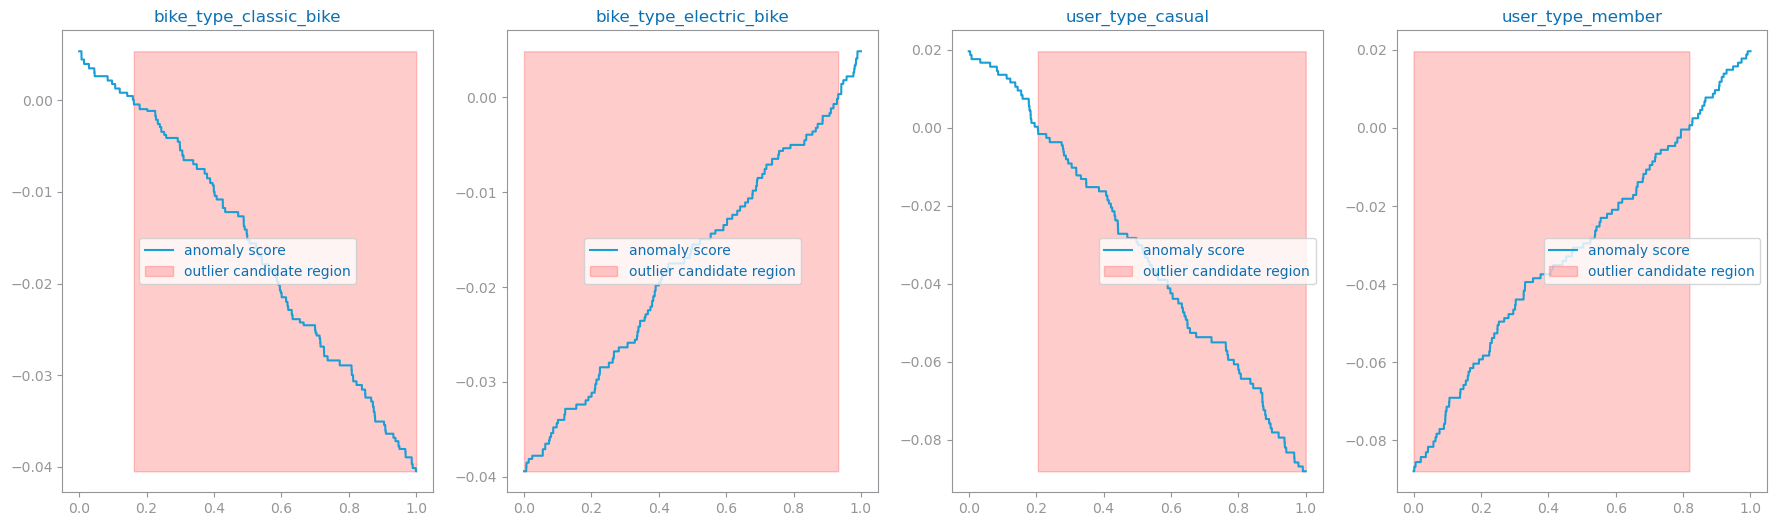

In [192]:
from sklearn.ensemble import IsolationForest
fig, axs = plt.subplots(1, 4, figsize=(22, 6), facecolor='w', edgecolor='k')


for i, column in enumerate(df_outl.columns):
    isolation_forest = IsolationForest(contamination='auto') #behaviour="new"
    isolation_forest.fit(df_outl[column].values.reshape(-1,1))
    x = np.linspace(df_discrit_final[column].min(), df_outl[column].max(), len(df_outl)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(x)
    outlier = isolation_forest.predict(x)
    axs[i].plot(x, anomaly_score, label='anomaly score')
    axs[i].fill_between(x.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                        where=outlier==-1, color='r', alpha=.2, label='outlier candidate region')
    axs[i].legend()
    axs[i].set_title(column)

IndexError: index 6 is out of bounds for axis 0 with size 6

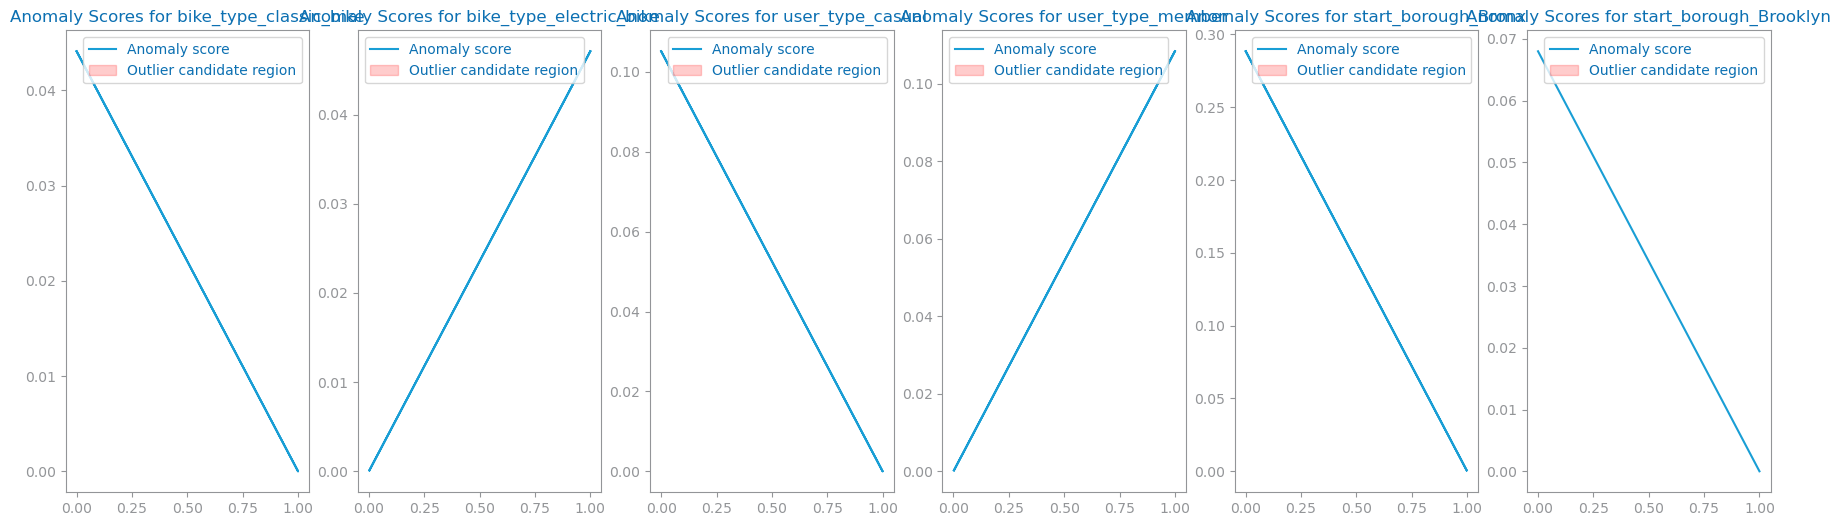

In [213]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np

# Configurando a visualização para 4 subgráficos
fig, axs = plt.subplots(1, 6, figsize=(22, 6), facecolor='w', edgecolor='k')

# Ajustando o parâmetro contamination (você pode ajustar conforme necessário)
contamination_value = 0.01  # Exemplo: 5% dos dados como outliers

# Percorrendo as colunas do seu DataFrame
for i, column in enumerate(df_outl.columns):
    isolation_forest = IsolationForest(contamination=contamination_value)  # Ajuste aqui
    isolation_forest.fit(df_outl[column].values.reshape(-1, 1))  # Ajustando a coluna para o modelo
    
    # Obtendo a pontuação de anomalia (anomaly score)
    anomaly_score = isolation_forest.decision_function(df_outl[column].values.reshape(-1, 1))
    outlier = isolation_forest.predict(df_outl[column].values.reshape(-1, 1))  # 1 para normal, -1 para outlier
    
    # Visualizando o gráfico
    axs[i].plot(df_outl[column].values, anomaly_score, label='Anomaly score')
    
    # Preenchendo a área dos outliers com cor vermelha
    axs[i].fill_between(range(len(df_outl[column])), 
                        np.min(anomaly_score), 
                        np.max(anomaly_score), 
                        where=outlier == -1, color='r', alpha=0.2, label='Outlier candidate region')
    
    axs[i].legend()
    axs[i].set_title(f"Anomaly Scores for {column}")

plt.tight_layout()
plt.show()


## Bivariate visual inspection using scatter plots



## Multivariate visual inspection using scatter plots


# Comparação entre Grupos


# TO DOs

- fazer analise de anomalias usando isolation_forest
    - ver chatgpt, como fazer
- fazer analise de padroes para user_type = member e casuais, para perceber o tipo de viagem mais frquente para cada tipo de utilizado